# Madden-Julian Oscillation

## Overview

Madden-Julian Oscillation (MJO) reprseents the largest subseasonal (30 to 90 day) atmospheric variability in the low latitude tropical atmosphere. MJO is an eastward traveling atmospheric pattern, moving between 4 to 8 m/s, which influences the location and strength of rainfall in the tropics

<img src="https://www.climate.gov/sites/default/files/2021-10/MJO_lrg.png">_(Image credit: [Climate.gov](https://www.climate.gov/news-features/blogs/enso/what-mjo-and-why-do-we-care))_

MJO was discovered in [1971 by Roland A. Madden and Paul R. Julian](https://doi.org/10.1175%2F1520-0469%281971%29028%3C0702%3ADOADOI%3E2.0.CO%3B2) at the National Center for Atmospheric Research (NCAR)

## Wheeler-Hendon Phase Diagram

### Overview

Wheeler-Hendon is a phase plot and diagnostics tool ([Wheeler and Hendon, 2004](https://doi.org/10.1175/1520-0493(2004)132%3C1917:AARMMI%3E2.0.CO;2)) to quantify the strength and significance of the MJO over time. The plot represents the Real-Time Multivariate MJO (RMM) which is made up of a pair of empirical orthogonal functions (EOF) from the combined equatorially averaged 850-hPa and 200-hPa zonal wind and the outgoing longwave radiation (OLR)

- Outgoing Longwave Radiation: The longwave radiation emitted from the top of the Earth's atmosphere into space
- Zonal wind: The zonal wind anomaly at 200-hPa and 850-hPa represents the changes in the atmospheric circulation

The pair of principal components from the EOFs form two indices: RMM1 and RMM2. The phase relationship between the two zonal winds determine the motion of the MJO

- **RMM1**: Represents the MJO's amplitude, where a larger RMM1 indicates stronger MJO activity. Negative values indicate a inactive or suppressed MJO phase and positive values indicate an active or enhanced MJO circulation
- **RMM2**: Represents the MJO's phase, where the phase determines the geographic position of the MJO's convection center. It is split into eight phases, each linked to a specific equatorial region

<table>
    <tr>
        <th>
            <img src="../_static/images/mjo_phases.jpg">
        </th>
        <th>
            <img src="../_static/images/mjo_rmm.jpg">
        </th>
    </tr>
</table>

### Workflow

In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker  # force integar ticks on axis
import matplotlib.lines as lines  # add phase division lines

#### Example Data

For the purpose of this notebook, we will be pulling data from NOAA's Physical Science Laboratory. PSL offers near real-time and historical RMM MJO data.

In [67]:
def retrieve_NOAA_data(data_type=None):
    # https://www.psl.noaa.gov/mjo/
    url = f"https://www.psl.noaa.gov/mjo/mjoindex/{data_type.lower()}.cpcolr.1x.txt"
    column_names = ["YYYY", "MM", "DD", "HH", "RMM1", "RMM2", "Phase"]
    try:
        df = pd.read_csv(url, sep=r'\s+', header=None, names=column_names)
        print(f"Retrieving data from: {url}")
        return df
    except Exception:
        print(f"invalid url: {url}")
        return pd.DataFrame(columns=column_names)

We will be retrieving the data related to the Real-time OLR MJO Index (ROMI). [See PSL MJO](https://www.psl.noaa.gov/mjo/) for more daily MJO index values for dates from 1979

In [68]:
noaa_df = retrieve_NOAA_data("ROMI")
noaa_df

Retrieving data from: https://www.psl.noaa.gov/mjo/mjoindex/romi.cpcolr.1x.txt


,YYYY,MM,DD,HH,RMM1,RMM2,Phase
0,1991,1,1,0,0.12526,-0.06945,0.14323
1,1991,1,2,0,0.18542,-0.04887,0.19175
2,1991,1,3,0,0.23960,-0.03933,0.24281
3,1991,1,4,0,0.27446,0.01990,0.27518
4,1991,1,5,0,0.27714,0.07555,0.28725
...,...,...,...,...,...,...,...
12826,2026,2,12,0,1.66383,1.37390,2.15776
12827,2026,2,13,0,1.76294,1.39719,2.24946
12828,2026,2,14,0,1.85446,1.38346,2.31365
12829,2026,2,15,0,1.97472,1.41888,2.43161


NOAA PSL MJO time series data as:
- YYYY: Year
- MM: Month (1-12)
- DD: Day (1-31)
- HH: Hour (always 0, can be ignored)
- RMM1: Real-Time Multivariate MJO Principal Component 1
- RMM2: Real-Time Multivariate MJO Principal Component 1
- Phase: Amplitude of MJO where sqrt(RMM1^2 + RMM2^2)

For the purpose of a plot, we will be using the datetime (YYYY-MM-DD) and RMM1 and RMM2

#### Plotting Phase Diagram

In [71]:
def mjo_phase_plot(
    data=None, radius=1, phase_type=None, month_colors=[], display_rmm_axis_label=False
):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    # set x and y axis labels
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax2 = ax.twinx()
    ax3 = ax.twiny()
    ax2.set_xlim(-4, 4)
    ax2.set_ylim(-4, 4)
    ax3.set_xlim(-4, 4)
    ax3.set_ylim(-4, 4)
    if not display_rmm_axis_label:
        ax.set_ylabel(
            "Phase 1 (Western Hemisphere, Africa) Phase 8", fontsize=20, labelpad=20
        )
        ax.set_xlabel("Phase 2 (Indian Ocean) Phase 3", fontsize=20, labelpad=20)
    else:
        ax.set_xlabel("RMM2", fontsize=20, labelpad=20)
        ax.set_ylabel("RMM1", fontsize=20, labelpad=20)
    ax2.set_ylabel("Phase 5 (Maritime) Phase 4", fontsize=20, labelpad=40, rotation=270)
    ax3.set_xlabel("Phase 7 (Western Pacific) Phase 6", fontsize=20, labelpad=20)

    # add amplitude circle
    amplitude_circle = plt.Circle((0, 0), radius, fill=False)
    ax.add_patch(amplitude_circle)

    # add phase diagram lines
    ## Phase 1-8
    phase_line = lines.Line2D([-4, -radius], [0, 0], linestyle="--", dashes=(5, 5))
    ax.add_line(phase_line)
    ## Phase 1-2
    phase_line = lines.Line2D(
        [-radius / np.sqrt(2), -4],
        [-radius / np.sqrt(2), -4],
        linestyle="--",
        dashes=(5, 5),
    )
    ax.add_line(phase_line)
    ## Phase 2-3
    phase_line = lines.Line2D([0, 0], [-radius, -4], linestyle="--", dashes=(5, 5))

    ax.add_line(phase_line)
    ## Phase 3-4
    phase_line = lines.Line2D(
        [radius / np.sqrt(2), 4],
        [-radius / np.sqrt(2), -4],
        linestyle="--",
        dashes=(5, 5),
    )
    ax.add_line(phase_line)
    ## Phase 4-5
    phase_line = lines.Line2D([radius, 4], [0, 0], linestyle="--", dashes=(5, 5))

    ax.add_line(phase_line)
    ## Phase 5-6
    phase_line = lines.Line2D(
        [radius / np.sqrt(2), 4],
        [radius / np.sqrt(2), 4],
        linestyle="--",
        dashes=(5, 5),
    )
    ax.add_line(phase_line)
    ## Phase 6-7
    phase_line = lines.Line2D([0, 0], [radius, 4], linestyle="--", dashes=(5, 5))
    ax.add_line(phase_line)
    ## Phase 7-8
    phase_line = lines.Line2D(
        [-radius / np.sqrt(2), -4],
        [radius / np.sqrt(2), 4],
        linestyle="--",
        dashes=(5, 5),
    )
    ax.add_line(phase_line)

    # add tick marks
    full_tickmarks = np.arange(-4, 4.5, 0.5)
    ax.set_xticks(full_tickmarks)
    ax.set_yticks(full_tickmarks)
    # hide tickmarks for top/right axis)
    ax2.set_yticks(full_tickmarks)
    ax3.set_xticks(full_tickmarks)

    # plot whole numbers integar tick marks
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax3.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    # increase length of major ticks
    ax.tick_params(which="major", length=10)
    ax2.tick_params(which="major", length=10)
    ax3.tick_params(which="major", length=10)

    # plot minor ticks every 0.25
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    ax3.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    # increase length of minor ticks
    ax.tick_params(which="minor", length=5)
    ax2.tick_params(which="minor", length=5)
    ax3.tick_params(which="minor", length=5)

    # plot with title
    first_index = data.iloc[0]
    start_date = (
        f'{int(first_index["YYYY"])}-{int(first_index["MM"])}-{int(first_index["DD"])}'
    )
    last_index = data.iloc[-1]
    end_date = (
        f'{int(last_index["YYYY"])}-{int(last_index["MM"])}-{int(last_index["DD"])}'
    )

    plt.title(
        f"MJO Phase: ROMI: {start_date} to {end_date}",
        fontsize=30,
        fontweight="bold",
        pad=20,
    )

    # Setup Months Text at Bottom of Plot
    if len(month_colors) == 0:
        # default colors for all twelve months
        month_colors = [
            "tomato",
            "dodgerblue",
            "orange",
            "green",
            "magenta",
            "yellow",
            "pink",
            "cyan",
            "gold",
            "lime",
            "darkviolet",
            "olive",
        ]

    month_dict = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }

    all_months = data["MM"].unique()
    all_month_names = [
        month_name
        for month_mm, month_name in month_dict.items()
        if month_mm in all_months
    ]  # convert number to name (example: 01 to Jan)

    # dynamic spacing for months
    start_index = -3.3 + ((12 - len(all_month_names)) * 0.28)
    for i, month in enumerate(all_month_names):
        if i == 0:
            # First Element
            text = ax.text(start_index, -3.7, month, color=month_colors[i], fontsize=13)
        else:
            # Remaining Elements
            text = ax.annotate(
                f"  {month}",
                xycoords=text,
                xy=(1, 0),
                verticalalignment="bottom",
                fontsize=13,
                color=month_colors[i],
            )

        # filter data based on each month
        last_index = data[data["MM"] == all_months[i]].index[-1]

        # include the first day of the next month in data to preserve continuity
        next_index = []
        if last_index + 1 in data.index:
            next_index = [last_index + 1]
        filtered_df = data.loc[
            (data["MM"] == all_months[i]) | (data.index.isin(next_index))
        ]
        x_data = filtered_df["RMM2"]
        y_data = -filtered_df["RMM1"]

        # Plot data
        plt.plot(x_data, y_data, zorder=1, c=month_colors[i])
        plt.scatter(x_data, y_data, zorder=1, c=month_colors[i])

        # plot dark mark at the start and end
        if i == 0:
            plt.scatter(x_data.iloc[[0]], y_data.iloc[[0]], c="black", s=150)
        if i + 1 == len(all_month_names):
            plt.scatter(x_data.iloc[[-1]], y_data.iloc[[-1]], c="black", s=150)

    # Annotate text every 5 days
    days_text = [5, 10, 15, 20, 25, 30]
    days_filtered = data[data["DD"].isin(days_text)]
    for index, row in days_filtered.iterrows():
        plt.text(
            x=row["RMM2"],
            y=-row["RMM1"],
            s=int(row["DD"]),
            ha="center",
            zorder=2,
            fontweight="bold",
        )
    plt.show()

#### Plot Diagram for 2025

Collect a subset of the data, the first three months of 2025

In [53]:
df_2026 = noaa_df[
    (noaa_df["YYYY"] == 2025)
    & ((noaa_df["MM"] == 1) | (noaa_df["MM"] == 2) | (noaa_df["MM"] == 3))
]

df_2026

,YYYY,MM,DD,HH,RMM1,RMM2,Phase
12419,2025,1,1,0,-0.15161,-0.83951,0.85309
12420,2025,1,2,0,-0.01538,-1.03555,1.03566
12421,2025,1,3,0,0.04397,-1.19613,1.19693
12422,2025,1,4,0,0.09447,-1.28177,1.28524
12423,2025,1,5,0,0.16386,-1.34737,1.35730
...,...,...,...,...,...,...,...
12504,2025,3,27,0,-0.15670,0.63108,0.65024
12505,2025,3,28,0,-0.07686,0.51473,0.52043
12506,2025,3,29,0,-0.07862,0.38960,0.39745
12507,2025,3,30,0,-0.20306,0.27428,0.34126


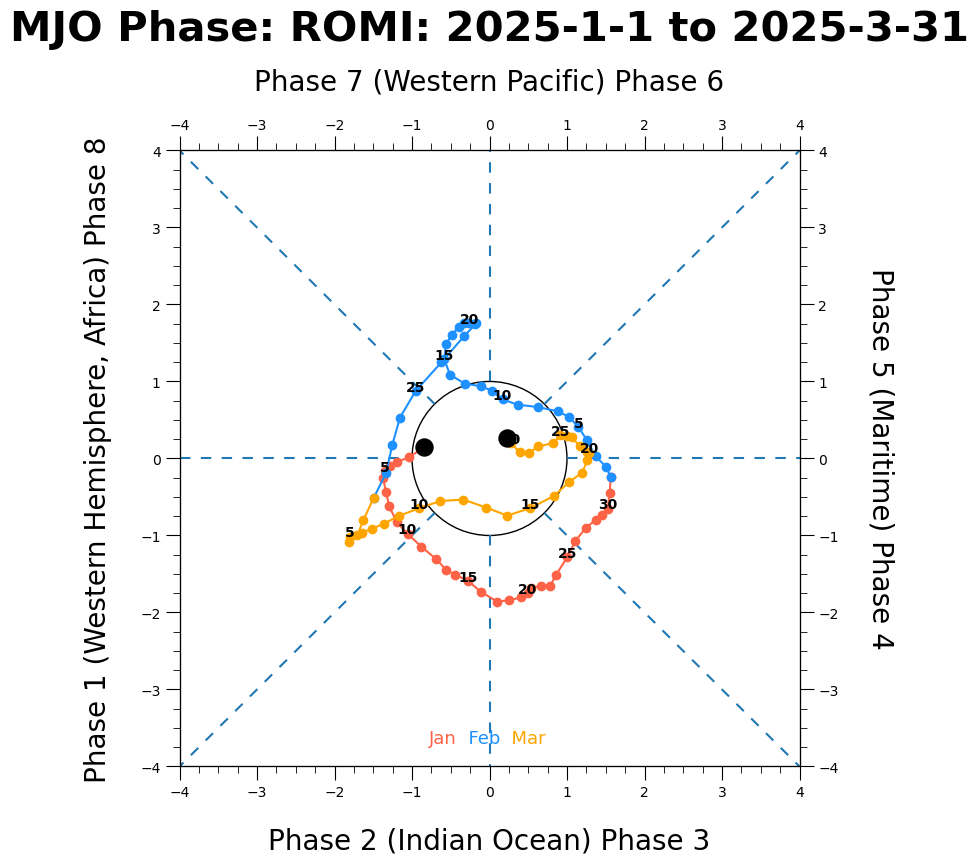

In [54]:
mjo_phase_plot(data=df_2026)

#### Plot Diagram Most Recent Data

Collect the last three months of data

In [72]:
all_years = noaa_df["YYYY"].unique()
most_recent_year = all_years[-1]
all_months_in_recent_year = noaa_df[(noaa_df["YYYY"] == most_recent_year)][
    "MM"
].unique()
print(
    f"Most recent year {most_recent_year} has {len(all_months_in_recent_year)} months"
)

Most recent year 2026 has 2 months


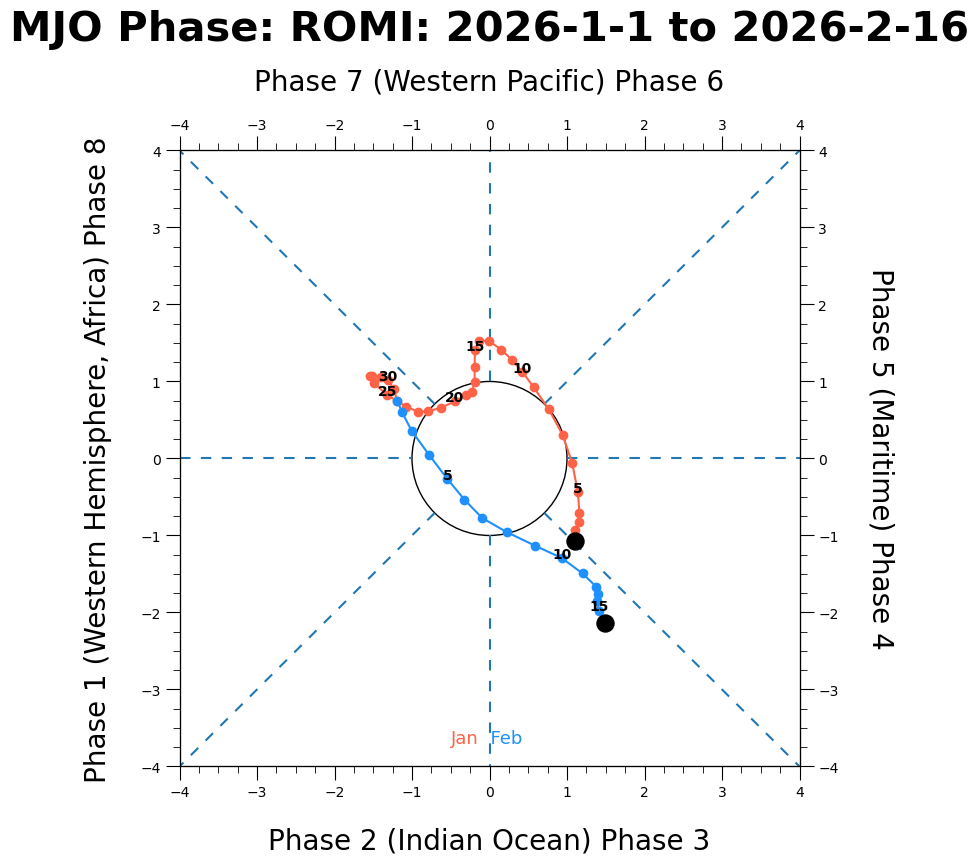

In [73]:
df_recent = noaa_df[(noaa_df["YYYY"] == most_recent_year)]
mjo_phase_plot(data=df_recent)

## Curated Resources

To learn more about Madden-Julian Oscillation:

- [NOAA (Physical Sciences Laboratory): Madden-Julian Oscillation](https://www.psl.noaa.gov/mjo/)
- [NWS (Climate Prediction Center): Current and Forecast Conditions](https://www.cpc.ncep.noaa.gov/products/precip/CWlink/MJO/mjo.shtml)